### MNIST Binary Classifier

In this notebook, we will implement a CNN classifier to classify the digits 0 and 1 from the MNIST dataset. The objective of this lesson is twofold:
* To build our first CNN classifier (binary).
* To demonstrate the importance of cross-entropy.
* To compare the speed of CPU vs GPU training.

Let's start with the ususal imports.

In [1]:
# For comparison purposes, we will force Tensorflow to use CPU here
# Cmment out this cell if you want to use GPU (if available)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

2024-07-16 20:07:51.147194: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 20:07:51.158975: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 20:07:51.252636: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 20:07:51.363528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 20:07:51.468960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

#### Dataset Loading

We have already inspected the MNIST dataset. We are going to load it now since we are going to use it for training the classifier.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Dataset params
num_classes = 10
size = x_train.shape[1]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


#### Dataset Preprocessing

In this example, we are going to train a binary classifier to classify the digits 0 and 1. Therefore, we have to remove all other digits (classes) from the dataset.

In [4]:
mask_train = np.logical_or(y_train == 0, y_train == 1)
x_train = x_train[mask_train, ...]
y_train = y_train[mask_train]

mask_test = np.logical_or(y_test == 0, y_test == 1)
x_test = x_test[mask_test, ...]
y_test = y_test[mask_test]

# Normalization
x_train = x_train/255
x_test = x_test/255

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    12665 samples
Test set:     2115 samples
Sample dims:  (12665, 28, 28)


#### Building the Classifier

We are going to build a relatively simple convolutional neural network (CNN) for this task.

In [5]:
inputs = Input(shape=(size, size, 1))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(1, activation="linear")(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,601 (21.88 KB)

 Trainable params: 5,601 (21.88 KB)

 Non-trainable params: 0 (0.00 B)

This is an extremely simple model (for a usual classification task) yet it already contains several thousand of (trainable) parameters. However, it still far less than the 12.5k parameters we used in the previous lesson.

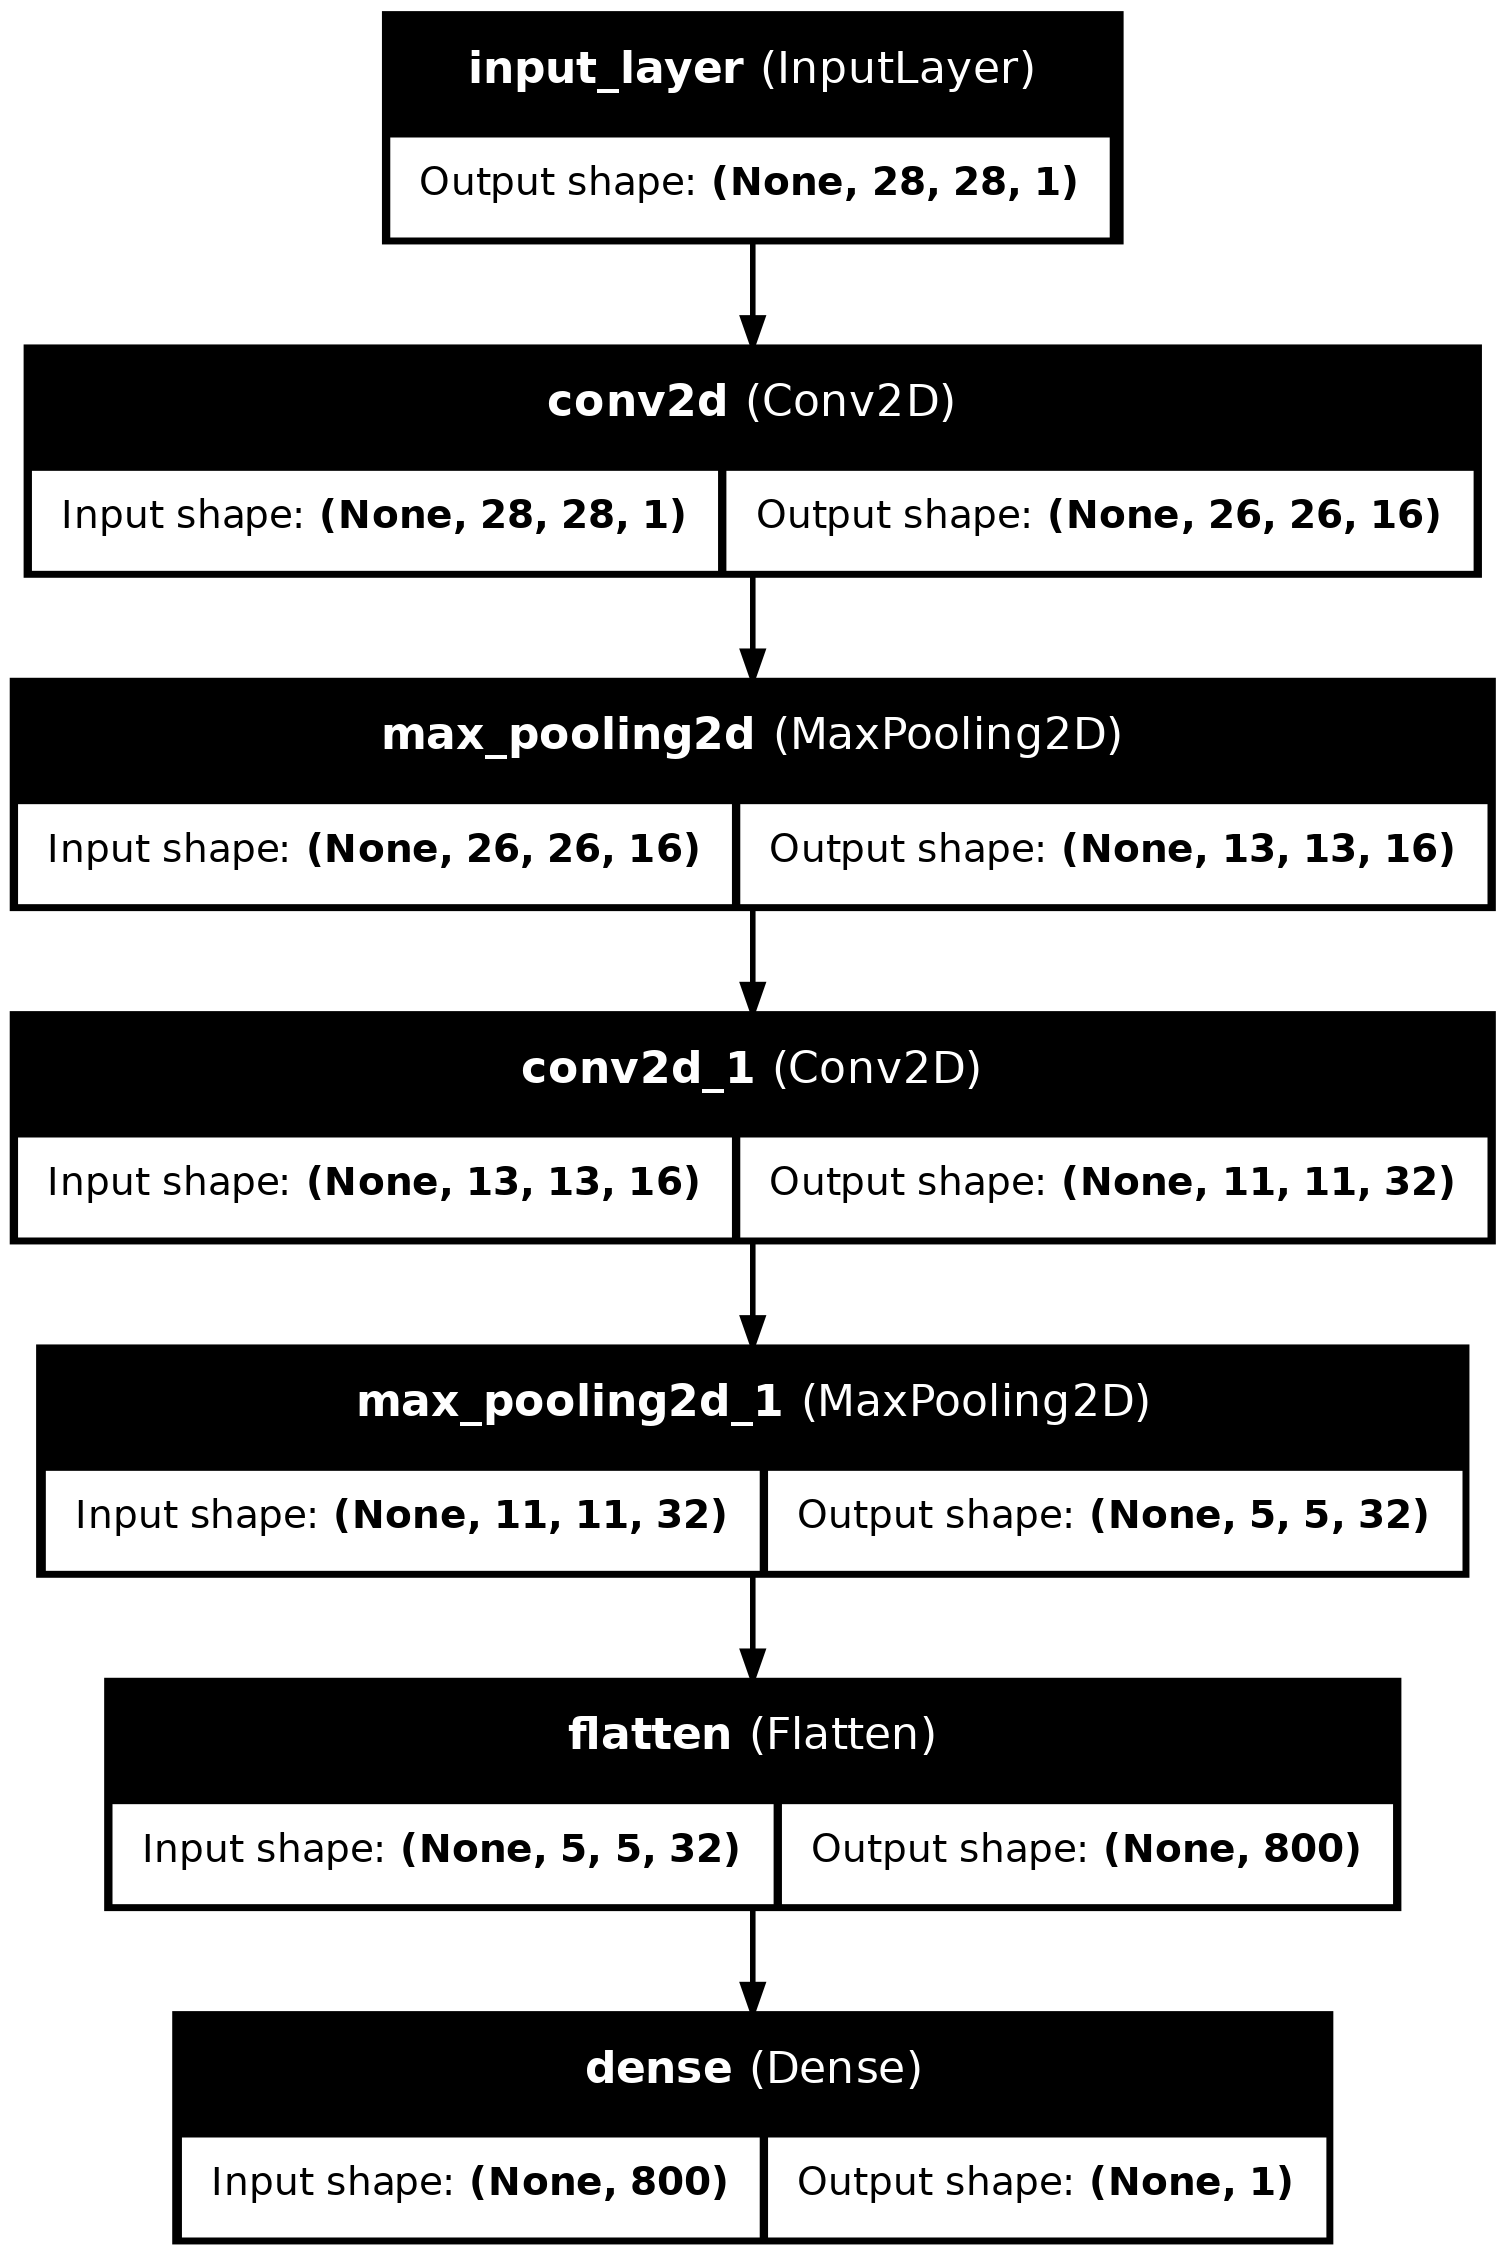

In [6]:
# Plot the model
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

#### Training

Let's now compile and train the model. We will use the well-known MSE as our loss function.

Note: MSE is **not** the suitable loss for classification task but it serves us here well for the demonstration purposes. We will learn how to design a classifier in a proper way later in this lesson ;-)

In [7]:
epochs = 25
batch_size = 128

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7870 - loss: 0.1982 - val_accuracy: 0.9976 - val_loss: 0.0082
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0078 - val_accuracy: 0.9992 - val_loss: 0.0048
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0054 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0042 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 5/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 6/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 8/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss:

Let's now plot the history to see the evolution of the training.

Train Acc      0.9999122619628906
Validation Acc 1.0


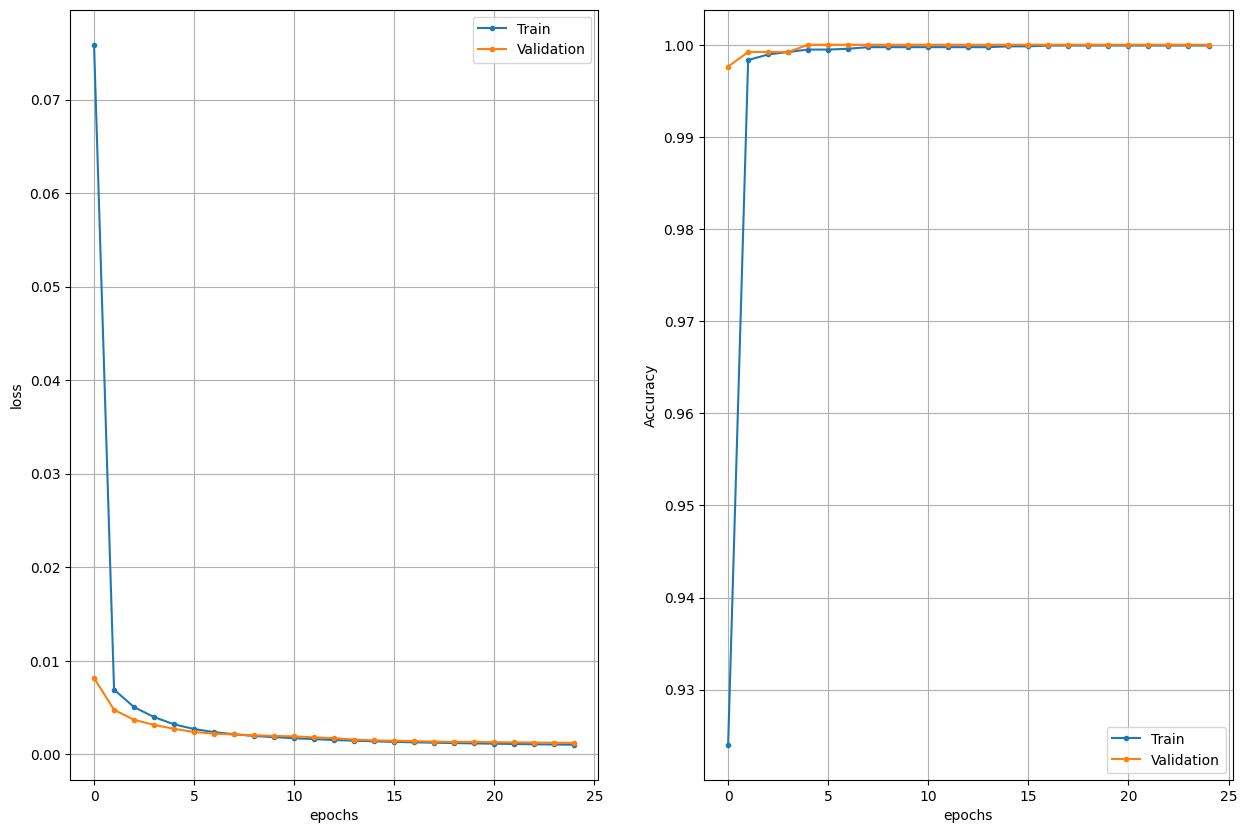

In [8]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

#### Evaluation

As we did in the previous lesson, we are going to evaluate the trained model.

In [9]:
# Compute the predictions on the test set
y_pred = model.predict(x_test)

print('True', y_test[0:5].flatten())
print('Pred', y_pred[0:5].flatten())

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
True [1 0 1 0 0]
Pred [ 0.9961232  -0.0147783   0.97840655  0.01453282 -0.02807983]


In [10]:
y_true = y_test.flatten()
y_pred = y_pred.flatten() > 0.5

# Overall accuracy
num_samples = len(y_true)
acc = np.sum(y_test == y_pred)/num_samples

# Accuracy for digit 0
mask = y_true == 0
acc0 = np.sum(y_test[mask] == y_pred[mask])/np.sum(mask)

# Accuracy for digit 1
mask = y_true == 1
acc1 = np.sum(y_test[mask] == y_pred[mask])/np.sum(mask)

print('Overall acc', acc)
print('Digit-0 acc', acc0)
print('Digit-1 acc', acc1)

Overall acc 0.9995271867612293
Digit-0 acc 0.9989795918367347
Digit-1 acc 1.0


We now visualise some of the evaluation results.

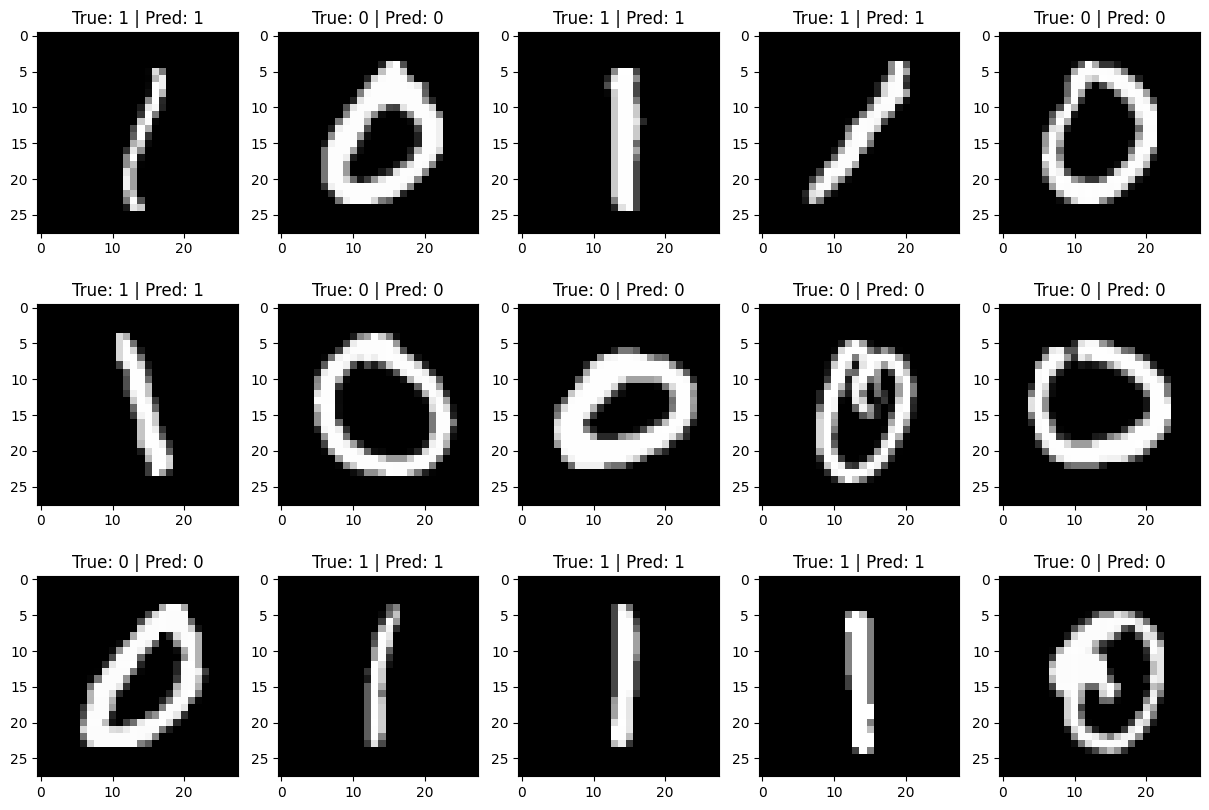

In [11]:
for ii in range(15):
    idx = np.random.randint(0, len(y_pred))
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...], cmap='gray')
    plt.title('True: ' + str(y_true[idx]) + ' | Pred: ' + str(int(y_pred[idx])))

#### CPU vs GPU

We are now going to repeat the process but training on the GPU. How did the training time changed?

### Full MNIST Classification

So far we have implemented a binary MNIST classifier that is able to classify handwritten zeros and ones. However, the MNIST dataset contains (obviously) more digits. How can we extend the classifier to account for all possible digits? Would a straightforward extension work? Let's see :-)

First, we are going to load the data (and keep all the digits!) and build the exactly same CNN as before.

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalization
x_train = x_train/255
x_test = x_test/255

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


In [13]:
inputs = Input(shape=(size, size, 1))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(1, activation="linear")(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,601 (21.88 KB)

 Trainable params: 5,601 (21.88 KB)

 Non-trainable params: 0 (0.00 B)

#### Tranining

We train the network the same way we did before. We are going to use the MSE as the loss function and demonstrate why it is not a good idea to use it for classification purposes :-) This is also the reason why we cannot use the built-in accuracy metric anymore.

Also note that the training now takes longer since we are using all the available data (we didn't filter out any samples).

In [14]:
epochs = 25
batch_size = 128

model.compile(loss="mse", optimizer="adam", metrics=["mse"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.2261 - mse: 8.2261 - val_loss: 2.0115 - val_mse: 2.0115
Epoch 2/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.0382 - mse: 2.0382 - val_loss: 1.5920 - val_mse: 1.5920
Epoch 3/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6942 - mse: 1.6942 - val_loss: 1.3478 - val_mse: 1.3478
Epoch 4/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4906 - mse: 1.4906 - val_loss: 1.1898 - val_mse: 1.1898
Epoch 5/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3494 - mse: 1.3494 - val_loss: 1.0989 - val_mse: 1.0989
Epoch 6/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2581 - mse: 1.2581 - val_loss: 1.0438 - val_mse: 1.0438
Epoch 7/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1947 - mse: 1.1947 - val_loss: 1.0075 - val_mse: 1.0075
Epoch 8/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1471 - mse: 1.1471 - val_loss: 0.9788 - val_mse: 0.9788
Epoch 9/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - lo

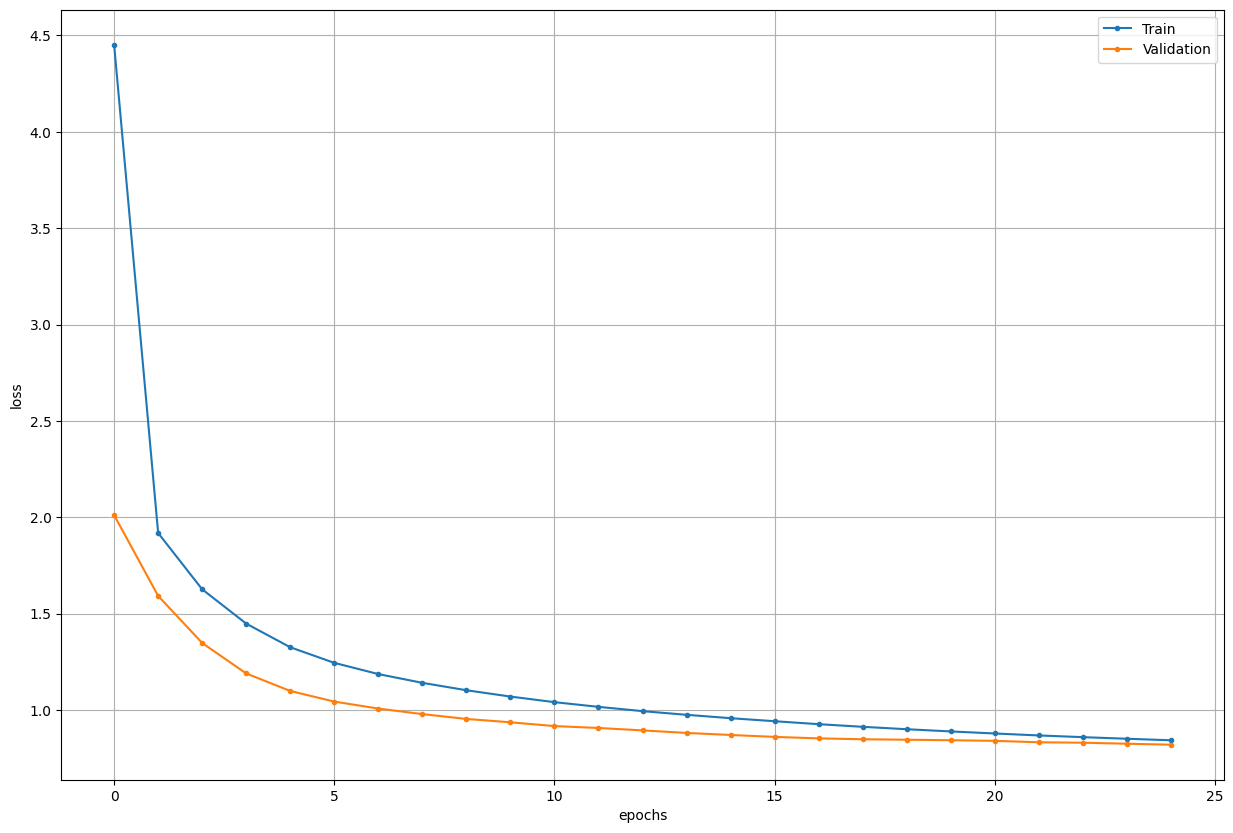

In [15]:
h = history.history
epochs = range(len(h['loss']))

plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])

#### Evaluation

No we are going to evaluate the classifier accuracy for all digits.

In [16]:
y_pred = model.predict(x_test)

print('True', y_test[100:105].flatten())
print('Pred', y_pred[100:105].flatten())

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
True [6 0 5 4 9]
Pred [6.546238  0.5475805 4.527465  3.5055423 8.724786 ]


In [17]:
y_true = y_test.flatten()
y_pred = y_pred.flatten()
digits = range(0, 10)

for digit in digits:
    mask = y_true == digit    
    # Count the true positives (the closest digit)
    tp = np.sum(np.abs(y_pred[mask] - digit) < 0.5)
    total = np.sum(mask)
    print('Digit-', digit, ' acc', tp/total)
    
print('y_true', y_true[mask])
print('y_pred', y_pred[mask])

Digit- 0  acc 0.44081632653061226
Digit- 1  acc 0.7127753303964758
Digit- 2  acc 0.4563953488372093
Digit- 3  acc 0.5257425742574258
Digit- 4  acc 0.43380855397148677
Digit- 5  acc 0.484304932735426
Digit- 6  acc 0.5250521920668059
Digit- 7  acc 0.561284046692607
Digit- 8  acc 0.45071868583162217
Digit- 9  acc 0.5322101090188305
y_true [9 9 9 ... 9 9 9]
y_pred [7.221909 8.954354 9.335479 ... 9.277623 9.105922 8.857106]


We see that the accuracy is actually quite bad and the predictions are not close enough to the ground truth. The reason is that we are using an inappropriate loss function for the classification task.

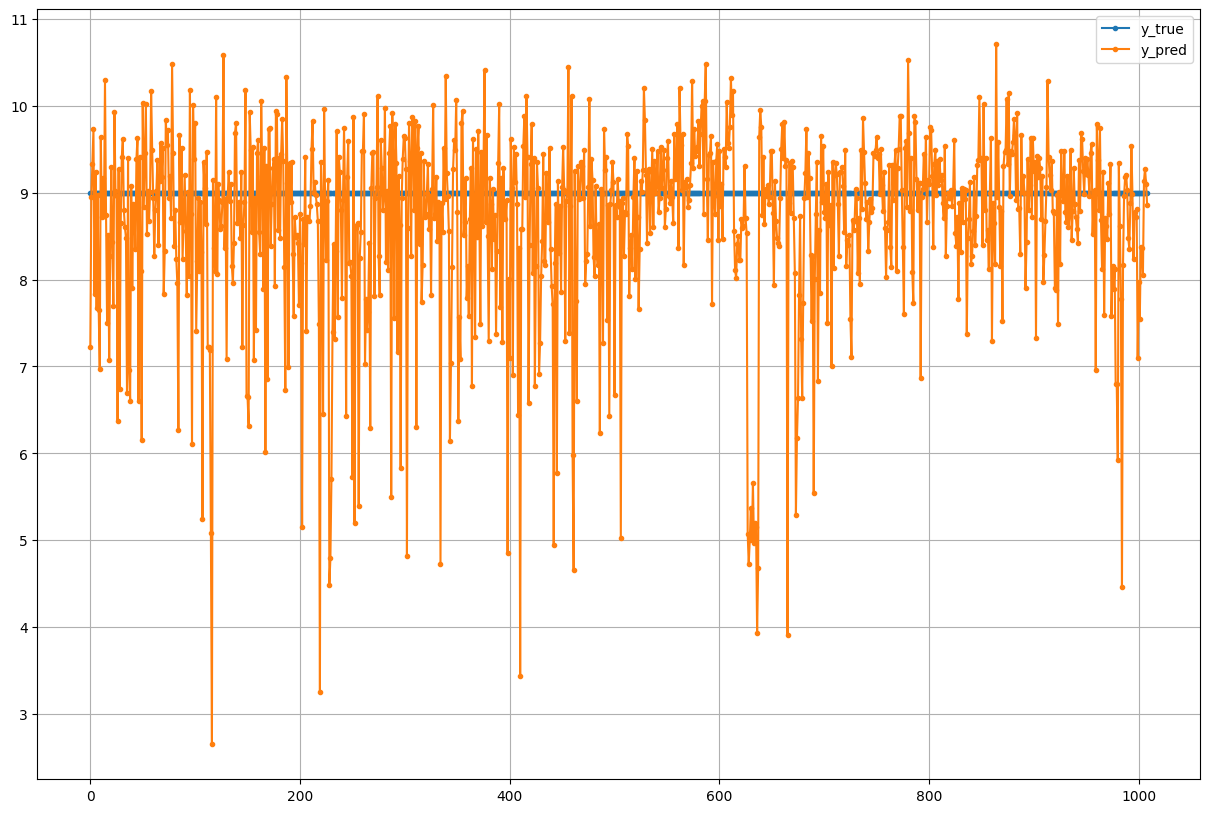

In [18]:
plt.plot(y_true[mask], '.-')
plt.plot(y_pred[mask], '.-')
plt.grid(True)
plt.legend(['y_true', 'y_pred'])